In [419]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt

from utils.preprocess import load_tof, Phi
from utils.plot import plot_predictions, make_palette
from image_processing import process

#from models.MixIRLS import MixIRLS

In [420]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X, y, phi = load_tof(FILE_PATH)

def add_bias(X):
    return np.c_[np.ones(len(X)), X]

def probability_to_std(prob):
    return np.sqrt(2) * erfinv(prob)

In [421]:
print(X.shape, y.shape)

(111034,) (111034,)


In [422]:
import numpy as np
from scipy.linalg import qr
from math import ceil

# weighted least squares
def weighted_ls(X, y, w=[]):
    if len(w) == 0:
        w = np.ones(len(y),)
    ws = w
    WX = ws[:, np.newaxis] * X
    if len(y.shape) > 1: # y is a matrix
        wy = ws[:, np.newaxis] * y
    else:
        wy = ws * y

    try:
        # Use numpy's built-in least squares solver
        beta = np.linalg.lstsq(WX, wy, rcond=None)[0]
    except np.linalg.LinAlgError:
        # If that fails, try using the pseudo-inverse
        XtWX = WX.T @ WX
        XtWy = WX.T @ wy
        beta = np.linalg.pinv(XtWX) @ XtWy

    sigma = np.mean((wy - (WX @ beta))**2, axis=0)
    return beta, sigma

def detect_outliers(res, corrupt_frac):
# input: res of size (n, K) and corrupt_frac between 0 and 1
# estimates outliers and returns an array with 1 for outlier and 0 for inlier

    n = res.shape[0]
    outlier_indicator = np.zeros((n,), dtype=np.bool_)
    M = np.min(res, axis=1) # take minimal res component per sample
    if corrupt_frac > 0: # mark outliers
        outlier_supp = np.argpartition(M, -round(corrupt_frac*n))[-round(corrupt_frac*n):]
        outlier_indicator[outlier_supp] = 1
   
    return outlier_indicator

def cluster_by_beta(beta, X, y, corrupt_frac):
# cluster samples into components
# if robustness > 0, mark outliers with c_hat < 0
    K = beta.shape[1]
    res = np.zeros((len(y), K))
    for k in range(K):
        res[:, k] = abs(X @ beta[:, k] - y)
    outlier_indicator = detect_outliers(res, corrupt_frac)
    I = np.argmin(res, axis=1)
    I[outlier_indicator.astype(np.int8)] = -1
    return I

def OLS(X, y, K, c):
    # perform OLS to each component individually according to c
    beta_hat = np.zeros((X.shape[1], K))
    sigma_hat = np.zeros((K,))
    for k in range(K):
        beta_hat[:,k], sigma_hat[k] = weighted_ls(X[c==k,:], y[c==k])
    return beta_hat


def MixIRLS(X, y, opts_input={}):
#
#   Sequential algorithm for Mixed Linear Regression
#   Written by Pini Zilber & Boaz Nadler / 2023
#
# INPUT:
# (X, y) = observations
# beta_init = initialization (K vectors)
# opts = options meta-variable
# errfun = error function w.r.t. the true beta
#
# OUTPUT:
# beta_hat = K vector estimates for beta
# iter = total iteration number (over both phases)

    ## set MixIRLS options
    # default options
    opts = dict()
    opts['verbose'] = False # let MixIRLS chat
    opts['T1'] = int(1e3) # phase I inner IRLS maximal number of iterations
    opts['T2'] = int(1e3) # phase II maximal number of iterations
    opts['wfun'] = lambda r: 1 / (1 + r**2) # IRLS function
    opts['rho'] = 1. # oversampling parameter. Set to 2 in real-data experiments
    opts['nu'] = 0.5 # tuning parameter. Set to 1 in real-data experiments
    opts['intercept'] = True
    opts['w_th_init'] = 0.1 # initialization for threshold parameter w_th
    opts['corrupt_frac'] = 0 # fraction of outliers
    opts['unknownK'] = False # if true, assumes K is unknown
    opts['tol'] = 2e-16 # tolerance for stopping criterion
    opts['errfun'] = lambda beta_hat: -1 # error function (unknown by default). Used only if verbose is on
    opts['phase_2'] = True
    opts['K'] = 2 # number of components
    
    # update options according to input opts,
    # in case some option is set differently from default
    for key in opts_input.keys():
        opts[key] = opts_input[key]

    # add intercept
    if opts['intercept']:
        X = np.c_[np.ones(len(X),), X]        

    n, d = X.shape
    
    ## set parameters
    K = 0
    if opts['unknownK']:
        K = 20
    else:
        K = opts['K']
        
    verbose = opts['verbose']

    # initialize beta
    beta_init = np.random.randn(d, K)

    # list to store sample indexes vor each K
    s_prim = []
    
    ###########################
    ######### phase I #########
    ###########################
    beta_hat = np.zeros((d,K))
    sigma_hat = np.zeros((K,))
    supports = np.ones((n,K), dtype=np.bool_) # active samples for each component regression
    w_th = opts['w_th_init']
    first_component_w = np.zeros_like(y)

    iter = 0
    k = 0
    while k < K:
        # must also iterate for last component, as some of the active samples might
        # belong to other components, or be data outliers

        # currenet active samples
        curr_X = X[supports[:,k],:]
        curr_y = y[supports[:,k]]

        # if we repeat due to too low w_th, don't calculate first
        # component again as we can take it as is
        if k==0 and np.any(first_component_w):
            # get weights from the first component
            if verbose:
                print('use same component 1')
            w = first_component_w
            beta_hat[:, 1:] = 0
        else:
            if verbose:
                print('find component ' + str(k+1))

            # find component
            beta, sigma, w, inner_iter, sprim = find_component(curr_X, curr_y, opts['wfun'], \
                opts['nu'], opts['rho'], opts['T1'], beta_init[:,k], verbose, w_th)
            iter = iter + inner_iter
            beta_hat[:,k] = beta.flatten()
            sigma_hat[k] = sigma[0]
            if k==0: # store first component in case we restart MixIRLS
                first_component_w = w
        
        next_oversampling = max(0, np.count_nonzero(w <= w_th) - opts['corrupt_frac'] * n) / d
        
        if not opts['unknownK'] and (k < K-1) and (next_oversampling < opts['rho']): # need more active samples
            if verbose:
                print('w_th ' + str(w_th) + ' is too low! Starting over...')
            w_th = w_th + 0.1
            k = 0
            continue
        else: # update index sets
            new_support = supports[:, k].copy()
            new_support[new_support] = np.invert(sprim) # w <= w_th
            
            if k < K-1: # not last component
                supports[:, k+1] = new_support

        if verbose:
            print('MixIRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tk: ' + str(k+1))

        # If K is unknown, fix K when the next component has too few
        # active samples
        if opts['unknownK'] and (next_oversampling < opts['rho']):
            K = k+1
            beta_hat = beta_hat[:, :K]
            sigma_hat = sigma_hat[:K]
            s_prim.append(sprim)

            if verbose:
                print('MixIRLS. found K=' + str(K) + ' components, stopping here')
            break

        s_prim.append(sprim)
        k = k + 1

    ###########################
    ######## phase II #########
    ###########################
    iter_phase2 = 0
    if opts_input['phase_2']:
        beta_diff = 1
        while (beta_diff > opts['tol']) and (iter_phase2 < opts['T2']):
            beta_hat_prev = beta_hat
            res2 = np.zeros((len(y), K))
            for k in range(K):
                res2[:, k] = np.abs(X @ beta_hat[:, k] - y.flatten())**2

            # caluclate weights (here a component's weight depends on the other
            # components' weight)
            w = 1 / (res2 + 1e-16)
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]
            highs = np.any(w>=2/3, axis=1)
            w_highs = w[highs,:]
            w_highs[w_highs>=2/3] = 1
            w_highs[w_highs<2/3] = 0
            w[highs,:] = w_highs
            lows = np.any(w<1/K, axis=1)
            w_lows = w[lows,:]
            w_lows[w_lows<1/K] = 0
            w[lows,:] = w_lows
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]

            # ignore estimated outliers
            outlier_indicator = detect_outliers(res2, opts['corrupt_frac'])
            samples_to_use = ~outlier_indicator
            # calculate new beta_hat
            for k in range(K):
                    b, s =  weighted_ls(X[samples_to_use,:], y[samples_to_use], w[samples_to_use,k])
                    beta_hat[:, k] = b.flatten() 
                    sigma_hat[k] = s[0]
            beta_diff = np.linalg.norm(beta_hat - beta_hat_prev, 'fro') / np.linalg.norm(beta_hat, 'fro')
    
            # update iter and report
            iter_phase2 = iter_phase2 + 1
            if verbose and (iter_phase2 % 10 == 0):
                print('Mix-IRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tphase2-iter: ' + str(iter_phase2))

    iter_tot = iter + iter_phase2
    return beta_hat.T, sigma_hat, s_prim, iter_tot, supports


## auxiliary functions
def find_component(X, y, wfun, nu, rho, iterlim_inner, beta_init, verbose, w_th):
    # INPUT:
    # wfun = IRLS reweighting function
    # nu = tuning parameter used in IRLS reweighting function
    # rho = minimal oversampling to detect component
    # iterlim_inner = max inner iters
    # beta_init - initialization
    # OUTPUT:
    # beta = regression over large weights
    # w = final weights
    # iter = inner iters done
    
    d = X.shape[1]
    _, w, iter = MixIRLS_inner(X, y, wfun, nu, iterlim_inner, beta_init)
    I = w > w_th
    # I = np.argpartition(w, -ceil(rho * d))[-ceil(rho*d):]
    I_count = np.count_nonzero(I)
    beta, sigma = weighted_ls(X[I,:], y[I])
    if verbose:
        print('observed error: ' + str(np.linalg.norm(X[I,:] @ beta - y[I]) / np.linalg.norm(y[I])) + '. active support size: ' + str(I_count))
    return beta, sigma, w, iter, I


def MixIRLS_inner(X, y, wfun, nu, iterlim, beta_init=[]):
    # if beta_init is not supplied or == -1, the OLS is used
    
    n,d = X.shape

    beta = np.zeros((d,))
    Q, R, perm = qr(X, mode='economic', pivoting=True)
    if len(beta_init) == 0:
        beta[perm], sigma = weighted_ls(R, Q.T @ y)
    else:
        beta = beta_init
    # adjust residuals according to DuMouchel & O'Brien (1989)
    E, _ = weighted_ls(R.T, X[:, perm].T)
    E = E.T
    h = np.sum(E * E, axis=1)
    h[h > 1 - 1e-4] = 1 - 1e-4
    adjfactor = 1 / np.sqrt(1-h)
    # IRLS
    for iter in range(iterlim):
        # residuals
        r = adjfactor * (y.flatten() - X @ beta)
        rs = np.sort(np.abs(r))
        # scale
        s = np.median(rs[d:]) / 0.6745 # mad sigma
        s = max(s, 1e-6 * np.std(y)) # lower bound s in case of a good fit
        if s == 0: # perfect fit
            s = 1

        # weights
        w = wfun(r / (nu * s))

        # beta
        beta_prev = beta.copy()
        beta[perm], _ = weighted_ls(X[:,perm], y.flatten(), w)

        # early stop if beta doesn't change
        if np.all(np.abs(beta-beta_prev) <= np.sqrt(1e-16) * np.maximum(np.abs(beta), np.abs(beta_prev))):
            break

    return beta, w, iter


In [423]:
X, y = process(X,y.flatten(), noise_sensitivity=0.9)
phi = Phi(X)
#plt.scatter(X, y, alpha=0.2, color='grey', s=0.1)
#plt.show()

data = np.vstack([X,y,phi.flatten()]).T
data = np.unique(data, axis=0)
X, y, phi = data[:,0], data[:,1], data[:,2]

In [441]:
opts = dict()
opts['verbose'] = False
opts['intercept'] = True
opts['unknownK'] = False
opts['K'] = 3
opts['phase_2'] = False

opts['rho'] = 2
opts['nu'] = 0.5
opts['w_th_init'] = 0.1

#opts['verbose'] = False # let MixIRLS chat
#opts['T1'] = int(1e3) # phase I inner IRLS maximal number of iterations
#opts['T2'] = int(1e3) # phase II maximal number of iterations
#opts['wfun'] = lambda r: 1 / (1 + r**2) # IRLS function
#opts['rho'] = 1. # oversampling parameter. Set to 2 in real-data experiments
#opts['nu'] = 0.5 # tuning parameter. Set to 1 in real-data experiments
#opts['w_th_init'] = 0.1 # initialization for threshold parameter w_th
#opts['corrupt_frac'] = 0 # fraction of outliers
#opts['unknownK'] = False # if true, assumes K is unknown
#opts['tol'] = 2e-16 # tolerance for stopping criterion
#opts['errfun'] = lambda beta_hat: -1 # error function (unknown by default). Used only if verbose is on

#phi = Phi(X)

exponents = [-1/2, 1/2] 
phi = Phi(X, exponents)
beta, sigma, sprim, iter, supports = MixIRLS(phi, y.reshape(-1,1), opts_input=opts)
S = len(sprim)
colors = make_palette(S)
print(iter)


409


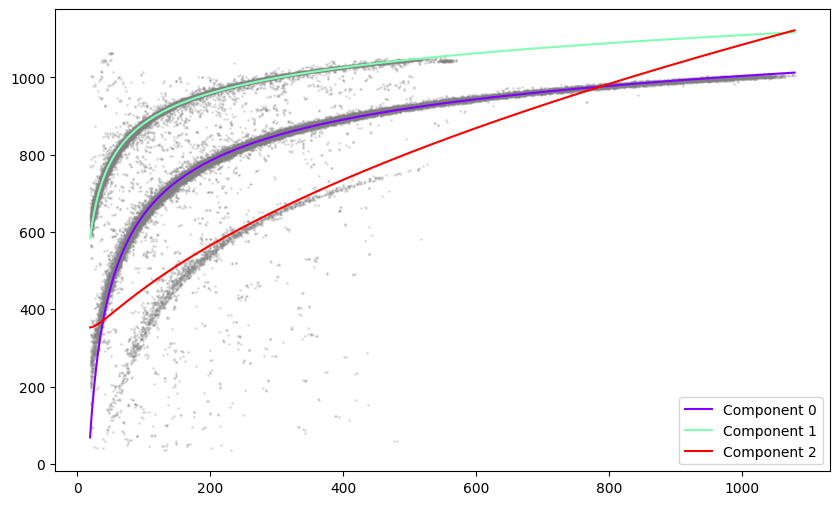

Points in support for component 0:  28779
  Number of points in component 0:  16635


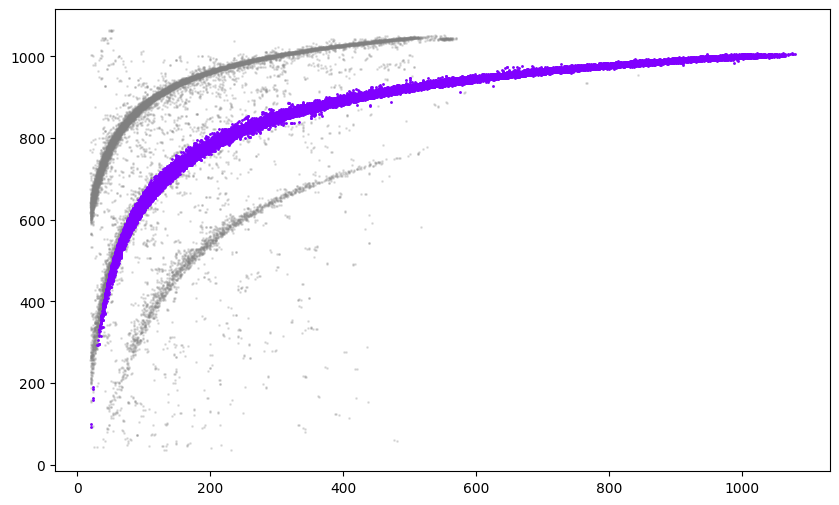

Points in support for component 1:  12144
  Number of points in component 1:  7219


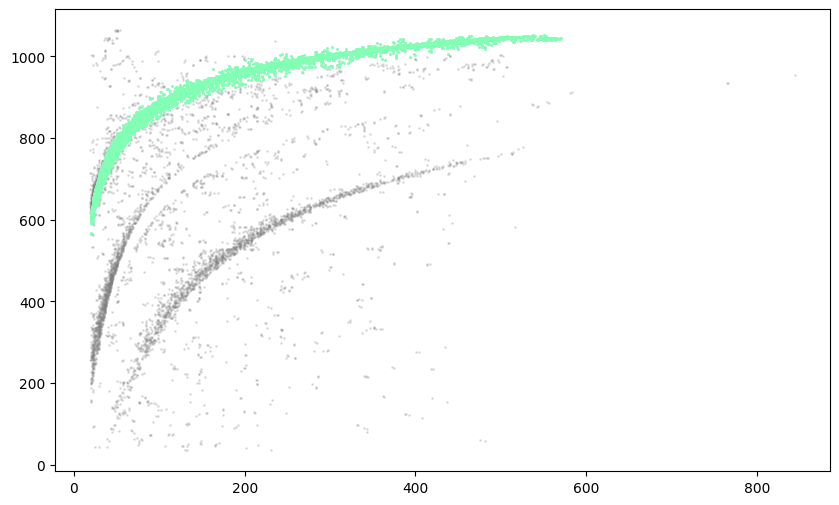

Points in support for component 2:  4925
  Number of points in component 2:  3516


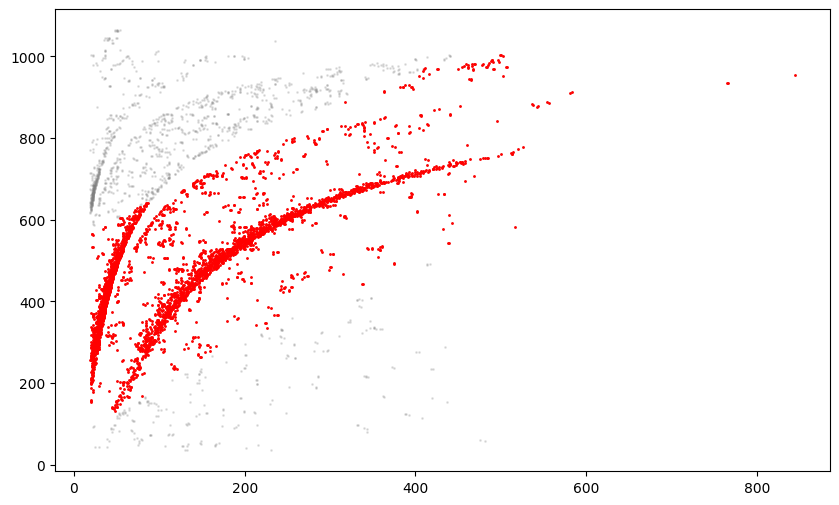

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)

for s in range(S):
    i = sprim[s]
    # Plot component points
    #plt.scatter(X[i], y[i], alpha=0.3, color=colors[s], s=1, label=f"Component {s}")
    
    # Sort based on X values but keep track of indices
    sort_idx = np.argsort(X)
    
    # Use the same indices to sort phi values
    if opts['intercept']:
        phi_sorted = np.c_[np.ones(len(phi)), phi]
    else:
        phi_sorted = phi[i][sort_idx]

    PHI = add_bias(Phi(X[sort_idx], exponents))
    pred = PHI @ beta[s] # params of component

    # Plot prediction line against sorted X[sort_idx]
    plt.plot(X[sort_idx], pred, color=colors[s], label=f"Component {s}")
    #plt.fill_between(X[sort_idx], 
    #                        pred - 1*np.sqrt(sigma[s]), 
    #                        pred + 1*np.sqrt(sigma[s]), 
    #                        color=colors[s],
    #                        alpha=0.3)
    
plt.legend()
plt.show()


for s in range(S):
    
    i = supports[:,s] # points that were considered
    j = sprim[s] # points that were trained on, relative to support
    sort_idx = np.argsort(X[i])

    print(f"Points in support for component {s}: ", i.sum())
    print(f"  Number of points in component {s}: ", len(X[i][j]))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=1, color=colors[s])

    #x = np.linspace(X.min(), X.max(), len(j))
    # Calculate predictions using sorted phi
    PHI = add_bias(Phi(X[i][sort_idx], exponents))
    PRED = PHI @ beta[s]
   
    
    # Plot prediction line against sorted X
    plt.plot(PHI[i][sort_idx], PRED, color=colors[s], label=f"Component {s}")
    #plt.fill_between(X[i][sort_idx], 
    #                        PRED - 1*np.sqrt(sigma[s]), 
    #                        PRED + 1*np.sqrt(sigma[s]), 
    #                        color=colors[s],
    #                        alpha=0.3)
    plt.show()

In [426]:
line = np.linspace(start=1, stop=100, num=101, dtype=int)
y_data = np.empty(shape=(len(line)))
for x in line:
    n = x + np.random.normal(loc=0, scale=5)
    if x > 25 and x < 75:
        n = 10*x + np.random.normal(loc=0, scale=50) + 200
    y_data[x] = n


Points in support for component 0:  101
  Number of points in component 0:  52
Points in support for component 1:  49
  Number of points in component 1:  49


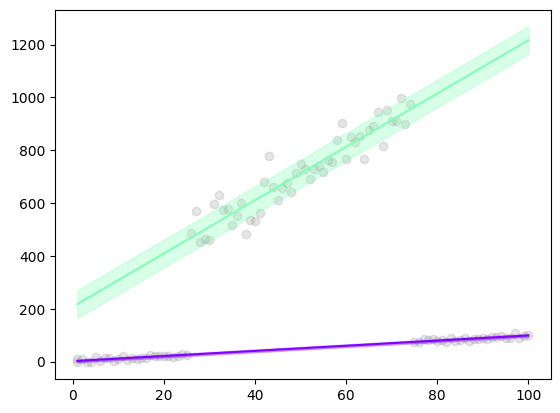

In [427]:
o = {'unknownK' : True, 
     'phase_2' : False,
     'rho' : 2,
     'nu' : 1,
     'w_th_init': 0.1}

beta, sigma, sprim, iter, supports  = MixIRLS(line, y_data.reshape(-1,1), opts_input=o)
S = len(sprim)
plt.scatter(line, y_data,  color='grey', alpha=0.2)
for s in range(S):
  i = supports[:,s] # points that were considered
  j = sprim[s] # points that were trained on, relative to support
  sort_idx = np.argsort(line[i])

  print(f"Points in support for component {s}: ", i.sum())
  print(f"  Number of points in component {s}: ", len(line[i][j]))
  
#  plt.scatter(line[i], y_data[i], alpha=0.2, color='grey')
#  plt.scatter(line[i][j], y_data[i][j], alpha=1, color=colors[s])

  PRED = add_bias(line) @ beta[s]
  
  # Plot prediction line against sorted X
  plt.plot(line, PRED, color=colors[s], label=f"Component {s}")
  plt.fill_between(line, 
                  PRED - 1*np.sqrt(sigma[s]), 
                  PRED + 1*np.sqrt(sigma[s]), 
                  color=colors[s],
                  alpha=0.3)
plt.show()